# Pylops - seismic interpolation

### Author: M.Ravasi

In this notebook I will implement and compare different ways to perform interpolation of seismic data onto a regular grid from data acquired by an irregularly sampled array of receivers.

The problem of seismic data interpolation is a very simple one, yet very ill-posed and hard to solve. Our forward modelling operator is a simple *restriction* or *sampling* operator which is applied along the spatial direction(s). 

$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where $\mathbf{y} = [\mathbf{y}_{R1}^T, \mathbf{y}_{R2}^T,..., \mathbf{y}_{RN^T}]^T$ and each vector  $\mathbf{y}_{Ri}$ contains all time samples recorded in the seismic data at the specific receiver $R_i$. Similarly, $\mathbf{x} = [\mathbf{x}_{r1}^T, \mathbf{x}_{r2}^T,..., \mathbf{x}_{rM}^T]$, contains all traces at the regularly and finely sampled idea array of receivers $r_i$.

The forward model simply selects a subset of sources/receivers from the input vector which is assumed to have a fine and regularly sampled array of receivers (which is what we wish to recover via inversion), while its adjoint places those values at the correct locations in the input vector. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import LinearOperator, cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import IRLS as IRLSpylops
from pylops.optimization.sparsity  import FISTA

# Linear events

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':101,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -60]
phi_m   = [0]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(xaxis, taxis, v, t0_m, theta_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=-36.829904 - u^T(Op^Tv)=-36.829904


### Inversion in time-space domain with spatial smoothing

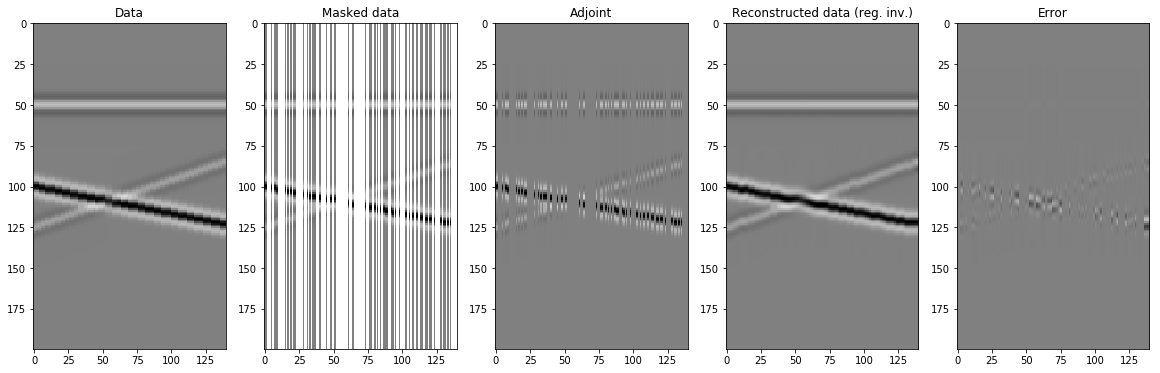

In [3]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['nx']*par['nt'], dims=(par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape( par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

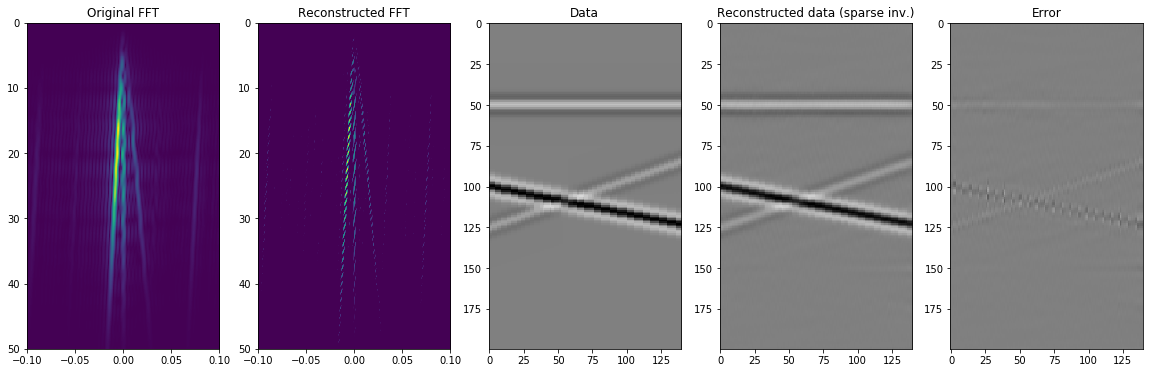

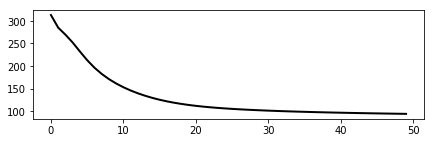

In [5]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-2, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft)
xl1 = np.real(xl1.reshape( par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in linear Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^T(Opu)=-3833.398747 - u^T(Op^Tv)=-3833.398747


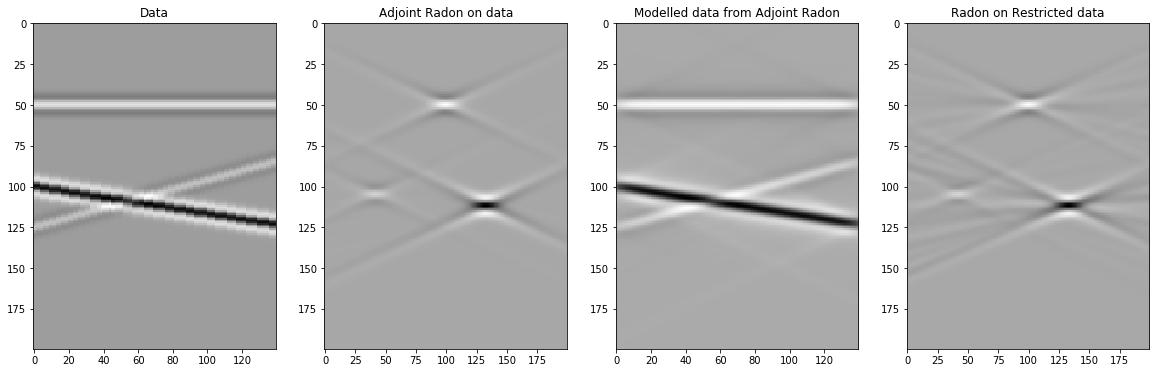

In [6]:
npx=200
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

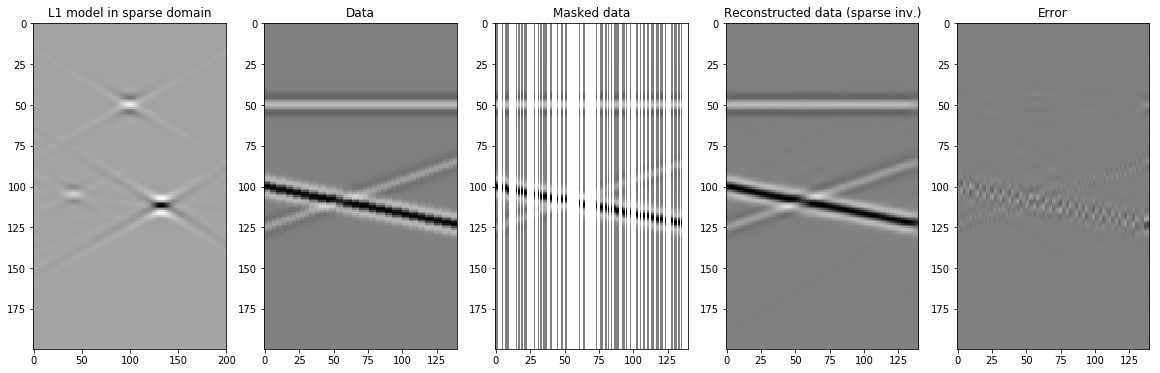

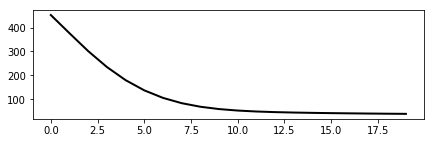

In [7]:
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=20, eps=5e-1, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

# Parabolic events

In [8]:
###### Input parameters
par = {'ox':0, 'dx':2,    'nx':140,
       'oy':0, 'dy':2,    'ny':100,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-6]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, x =  parabolic2d(x,t, t0_m, px_m, pxx_m,amp_m,wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=52.302758 - u^T(Op^Tv)=52.302758


### Inversion in time-space domain with spatial smoothing

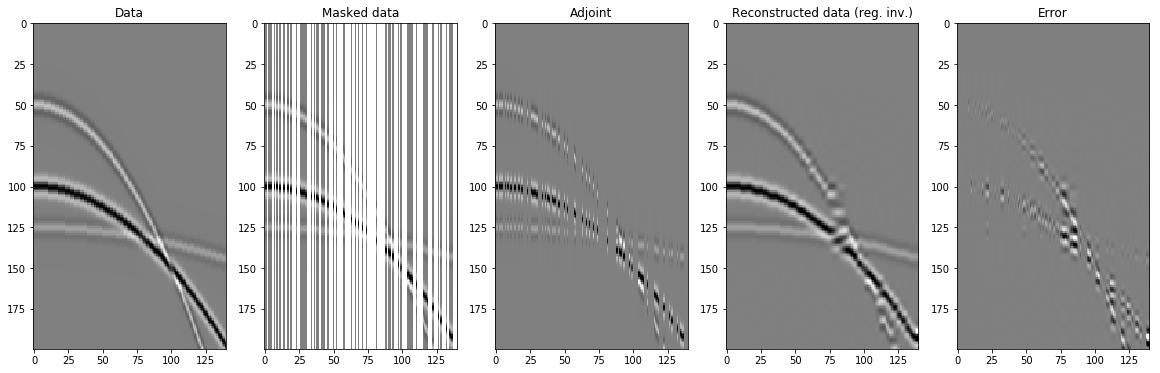

In [9]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['nx']*par['nt'], dims=(par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape( par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

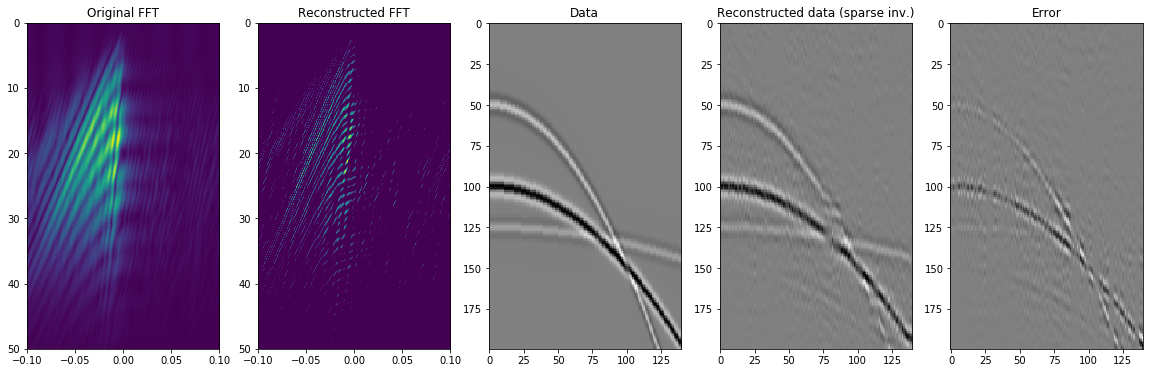

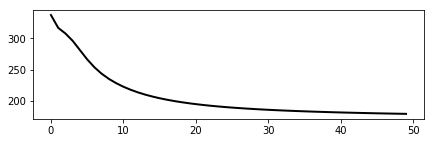

In [10]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
X = FFTop*x.flatten()
X = np.reshape(X, (nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-2, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft)
xl1 = np.real(xl1.reshape( par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.1, 0.1)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.1, 0.1)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^T(Opu)=-2333.708655 - u^T(Op^Tv)=-2333.708655


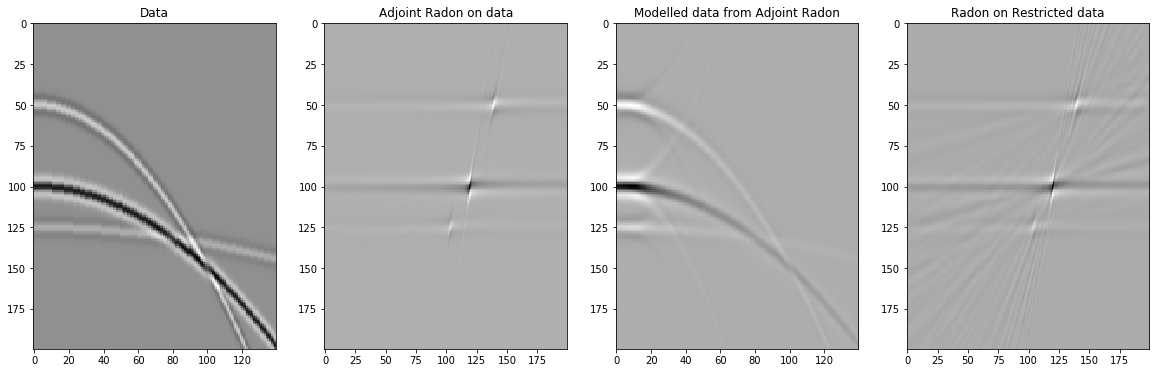

In [11]:
npx=200
pxmax = 5e-5
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=False, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

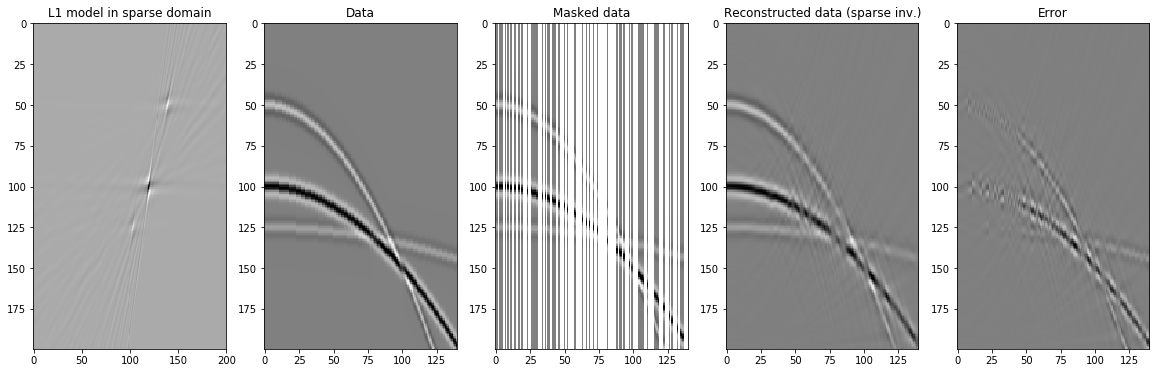

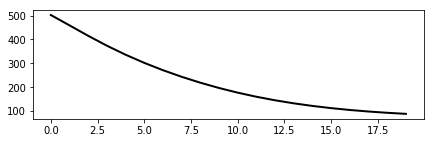

In [12]:
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=20, eps=5e-1, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in sliding linear Radon domain with sparsity-promoting solver

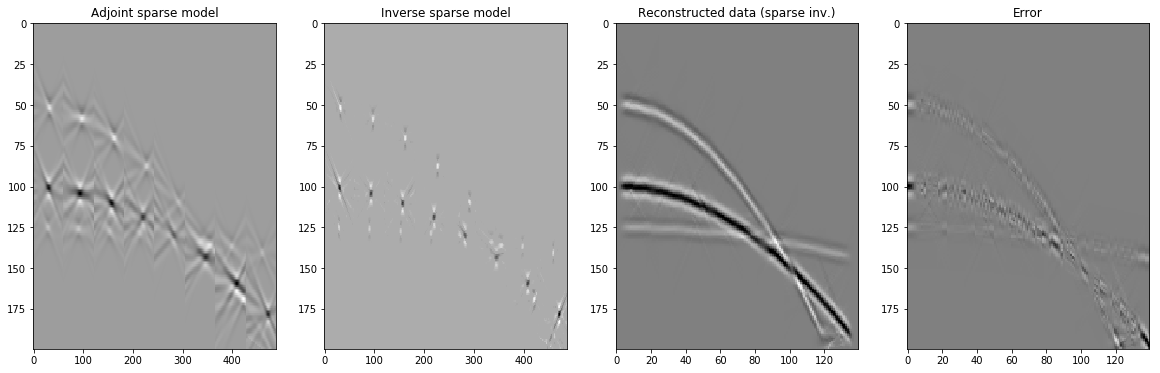

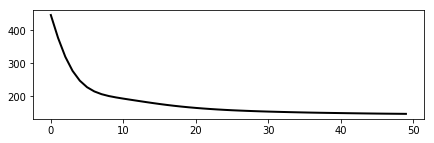

In [13]:
nwin = 26
nwins = 8
nover = 10
npx = 61
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                            kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims))

Rop1 = Rop*Slidop

# adjoint
padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

# inverse
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=50, eps=5e-1, returninfo=True)
xl1 = Slidop*pl1

pl1 = pl1.reshape(npx*nwins, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(padj.T, cmap='gray')
axs[0].set_title('Adjoint sparse model')
axs[0].axis('tight')
axs[1].imshow(pl1.T, cmap='gray')
axs[1].set_title('Inverse sparse model')
axs[1].axis('tight')
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight')

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

# Real data

In [16]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=215.666009 - u^T(Op^Tv)=215.666009


### Inversion in time-space domain with spatial smoothing

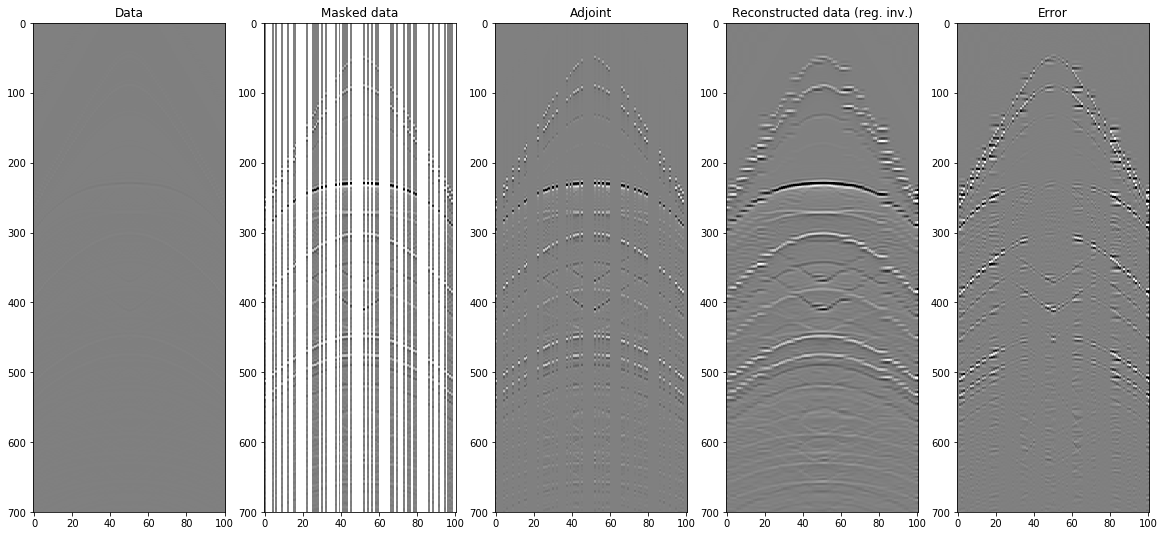

In [18]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['nx']*par['nt'], dims=(par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape( par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

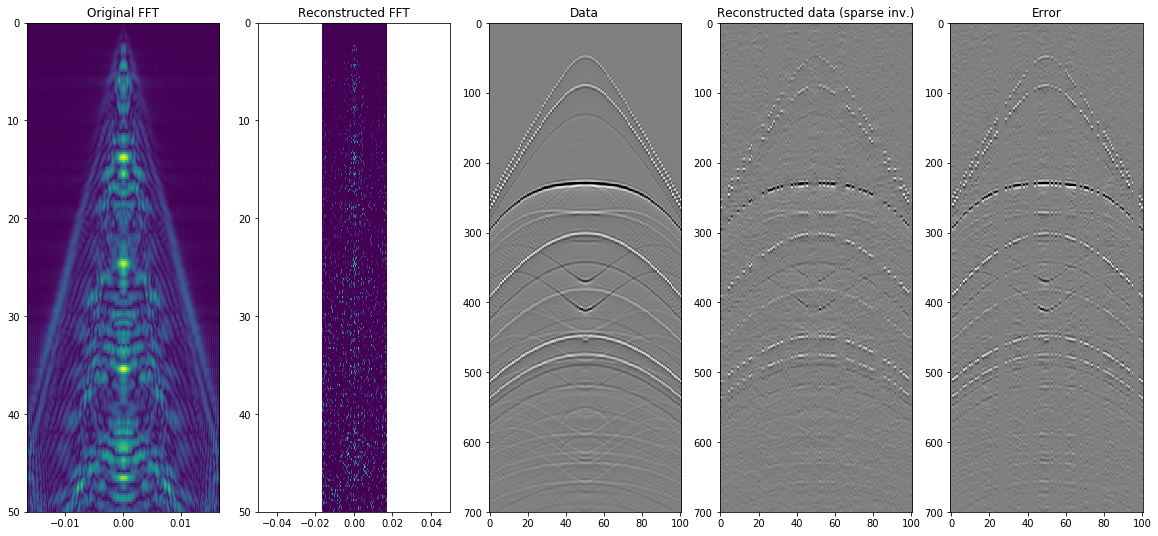

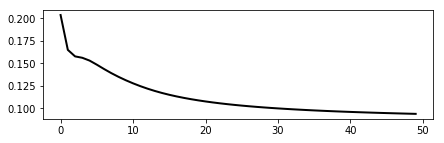

In [23]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-4, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft)
xl1 = np.real(xl1.reshape( par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[2].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=3176.300732 - u^T(Op^Tv)=3176.300732


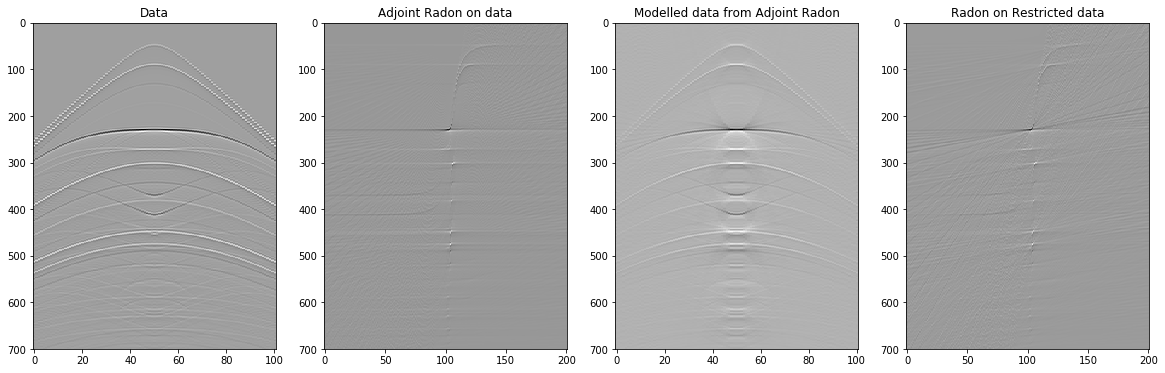

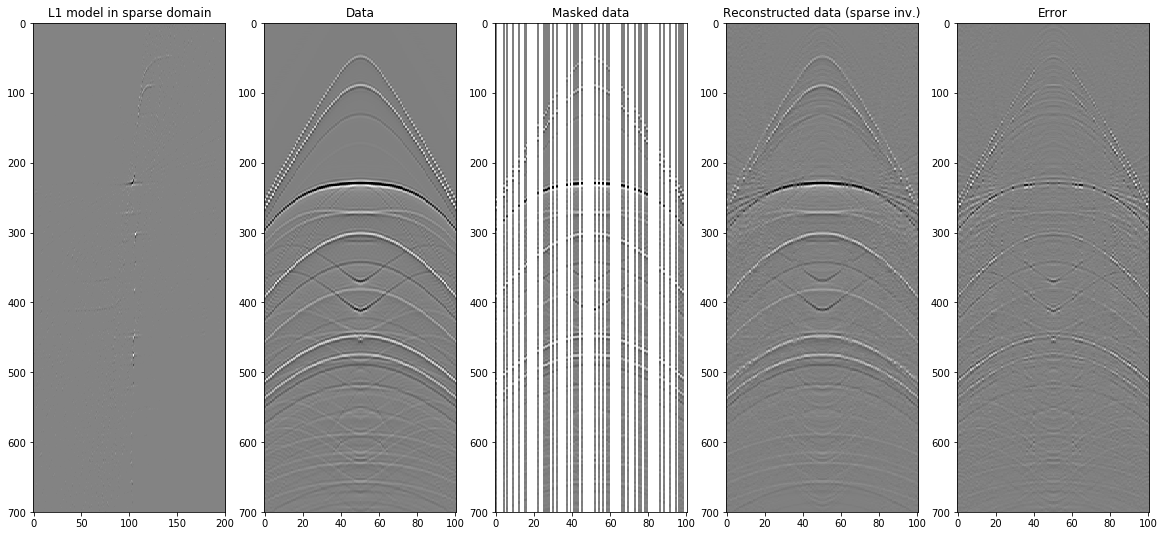

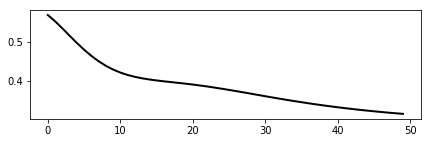

In [28]:
npx=201
pxmax = 5e-5
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=True, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

# Sparse inversion
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=50, eps=4e-2, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(pl1.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in sliding linear Radon domain with sparsity-promoting solver

(-0.5, 100.5, 699.5, -0.5)

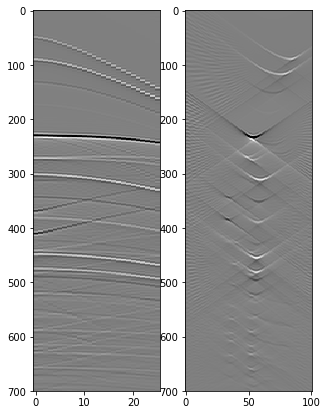

In [42]:
dx = par['dx']
nwin=26
nwins=6
nover=13
npx=101
pxmax = 5e-4
px = np.linspace(-pxmax, pxmax, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(taxis, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims))

# radon on one patch
x1 = x[2*nwin:3*nwin]
y1 = Op.H*x1.flatten()
y1 = y1.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 2, figsize=(5, 7))
axs[0].imshow(x1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].axis('tight')
axs[1].imshow(y1.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].axis('tight')

In [ ]:
# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(npx*nwins, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=100, eps=1e-3, returninfo=True)
xl1 = Slidop*pl1

pl1 = pl1.reshape(npx*nwins, par['nt'])
xl1 = xl1.reshape(par['nx'], par['nt'])

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(padj.T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[0].set_title('Adjoint Radon on data')
axs[0].axis('tight')
axs[1].imshow(padj_fromx.T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].set_title('Adjoint Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(pl1.T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].set_title('Inverse Radon on subsampled data')
axs[2].axis('tight')
axs[3].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight')
axs[5].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight')

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(padj.T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[0].set_title('Adjoint Radon on data')
axs[0].axis('tight')
axs[1].imshow(padj_fromx.T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].set_title('Adjoint Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(pl1.T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[2].set_title('Inverse Radon on subsampled data')
axs[2].axis('tight')
axs[3].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight')
axs[5].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight')

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);